Staffing and scheduling analysis of a 911 center.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, percentileofscore
from itertools import product

# Read data in
df = pd.read_csv('Phone_calls.csv')

# Exclude outbound calls
df = df[df['solacom-CallDirection'] != 'OUT']

# Convert Date Time to datetime
df['Date Time'] = pd.to_datetime(df['Date Time'])

# Convert Duration to time delta in seconds
df['Duration'] = pd.to_timedelta(df['Duration'], unit='S')

# Keep only calls from 2019
# df = df[df['Date Time'].dt.year == 2019]

# Reverse order so oldest entry is first, then find the time differences
df = df.reindex(index=df.index[::-1])
df['Difference'] = df['Date Time'] - df['Date Time'].shift()
df['Difference'].fillna(pd.Timedelta(seconds=0), inplace=True)

# Select only the difference column
diff = df['Difference']
# Get the shape
N = diff.shape[0]

# Keep differences only if less than an hour. Convert to seconds.
diff = diff[diff < pd.Timedelta('1 hour')].astype('timedelta64[s]')
# Get the shape
n = diff.shape[0]

In [14]:
df.head()

,Date Time,Duration,solacom-callType,solacom-CallDirection,solacom-hold-duration,solacom-DurationBeforeTransfer,solacom-transfer-duration,solacom-DurationAfterTransfer,solacom-Caller-RingTime,Difference
454280,2017-01-01 00:16:14,00:01:51,Admin,IN,NaN,NaN,NaN,NaN,0:00:01,00:00:00
454279,2017-01-01 00:23:34,00:00:56,SR911,IN,NaN,0:00:16,NaN,0:00:39,0:00:03,00:07:20
454277,2017-01-01 00:31:59,00:00:25,Admin,IN,NaN,NaN,NaN,NaN,0:00:02,00:08:25
454276,2017-01-01 00:34:10,00:02:40,SR911,IN,NaN,NaN,NaN,NaN,0:00:02,00:02:11
454275,2017-01-01 00:35:30,00:00:22,Admin,IN,NaN,NaN,NaN,NaN,0:00:01,00:01:20


In [15]:
# Number of removed data points
print('{} time deltas were 1 hour or greater.'.format(N-n))
print('{:.2f}% of the time deltas were removed'.format(100*(N-n)/N))

653 time deltas were 1 hour or greater.
0.18% of the time deltas were removed


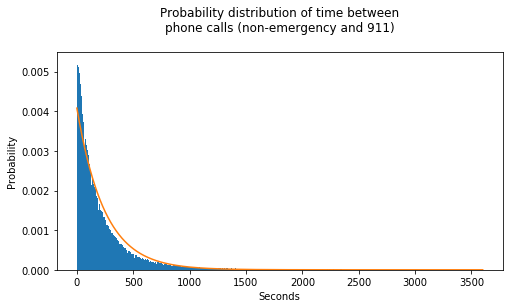

In [16]:
# Model the distribution
x_axis = np.linspace (0, 3600, 3600)
loc,scale = expon.fit(diff)
model = expon.pdf(x_axis, scale=scale)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(diff, bins='auto', density=True)
ax.plot(x_axis, model)
ax.set_xlabel('Seconds')
ax.set_ylabel('Probability')
ax.set_title('Probability distribution of time between\nphone calls (non-emergency and 911)\n')
plt.show()

In [21]:
print(percentileofscore(diff, 60), percentileofscore(diff, 600))

27.61496480010334 90.79151327262159


Given this model, the probability that the time between calls is a minute or less is about 27.6%. The probability that the time between calls is 10 minutes or less is about 90.8%.

The time between calls changes with the hour of the day, day of the week, and even time of year. For scheduling purposes, we'll consider each hour of the day, day of the week, and time of year (January-April, May-August, September-December).

In [22]:
# Create new columns
df['Hour'] = df['Date Time'].dt.hour
df['DOW'] = df['Date Time'].dt.dayofweek
df['Month'] = df['Date Time'].dt.month

df.head()

,Date Time,Duration,solacom-callType,solacom-CallDirection,solacom-hold-duration,solacom-DurationBeforeTransfer,solacom-transfer-duration,solacom-DurationAfterTransfer,solacom-Caller-RingTime,Difference,Hour,DOW,Month
454280,2017-01-01 00:16:14,00:01:51,Admin,IN,NaN,NaN,NaN,NaN,0:00:01,00:00:00,0,6,1
454279,2017-01-01 00:23:34,00:00:56,SR911,IN,NaN,0:00:16,NaN,0:00:39,0:00:03,00:07:20,0,6,1
454277,2017-01-01 00:31:59,00:00:25,Admin,IN,NaN,NaN,NaN,NaN,0:00:02,00:08:25,0,6,1
454276,2017-01-01 00:34:10,00:02:40,SR911,IN,NaN,NaN,NaN,NaN,0:00:02,00:02:11,0,6,1
454275,2017-01-01 00:35:30,00:00:22,Admin,IN,NaN,NaN,NaN,NaN,0:00:01,00:01:20,0,6,1


In [23]:
# Create lists for hour of the day, day of the week, and trimester options
hour = [h for h in range(24)]
dow = [i for i in range(7)]
trimester = {'spring':(1,2,3,4), 'summer':(5,6,7,8), 'fall':(9,10,11,12)}

In [24]:
# Create a list of dictionary keys containing all hour, day of week, and trimester combinations
combos = list(product(hour, dow, trimester))

# df broken down by hour of day, day of week, and trimester combinations
# i.e. 24 hours X 7 days X 3 trimesters = 504 combinations
breakdown = {c:df[(df['Hour']==c[0]) & (df['DOW']==c[1]) & (df['Month'].isin(trimester[c[2]]))] for c in combos}

Below are views of the distributions of time between subsequent phone calls. Each column is a different day of the week starting with Monday. Each row represents an hour, starting at 7 PM.

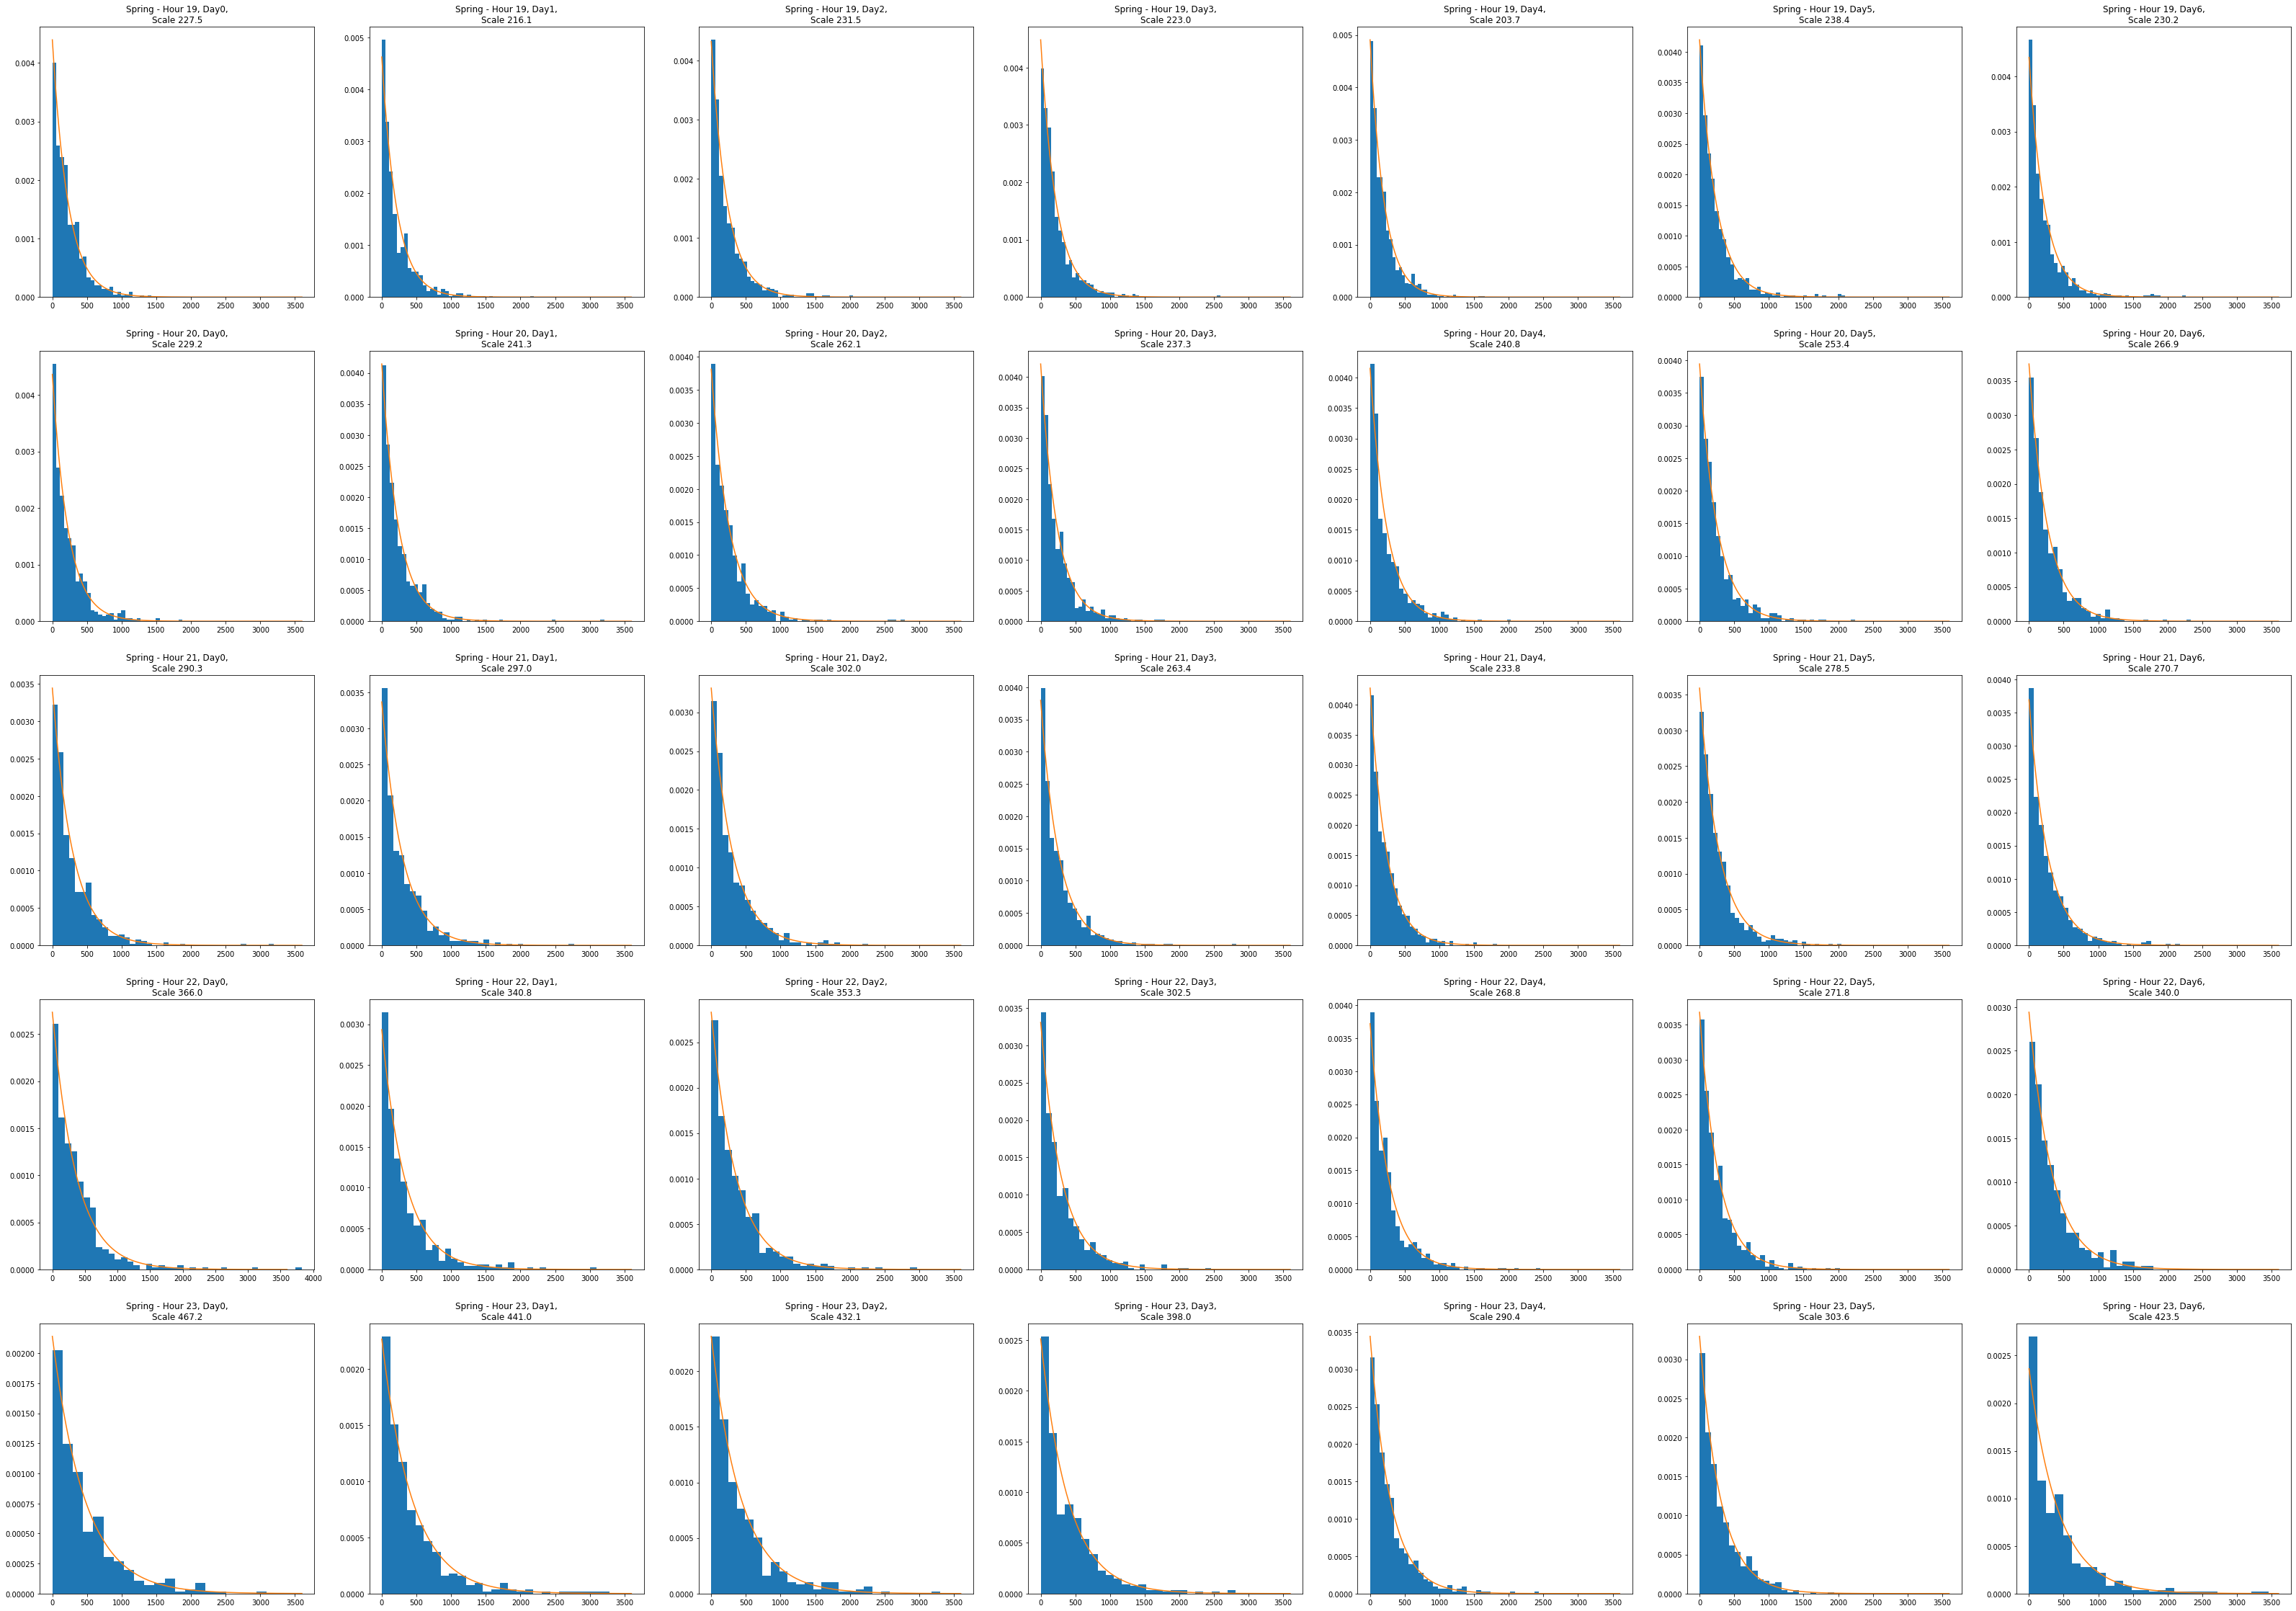

In [31]:
fig, ax = plt.subplots(nrows=5, ncols=7, figsize=(56, 40))

for h in range(19,24):
    for d in range(7):
        diff = breakdown[(h,d,'spring')]['Difference'].astype('timedelta64[s]')
        loc, scale = expon.fit(diff)
        model = expon.pdf(x_axis, scale=scale)
        ax[h%19,d].hist(diff, bins='auto', density=True)
        ax[h%19,d].plot(x_axis, model)
        ax[h%19,d].set_title('Spring - Hour ' + str(h) + ', Day' + str(d) + ',\nScale {:.1f}'.format(scale))
plt.show()

Like the diagram above, the views below depict the distribution of call handling times for the same days and hours as above.

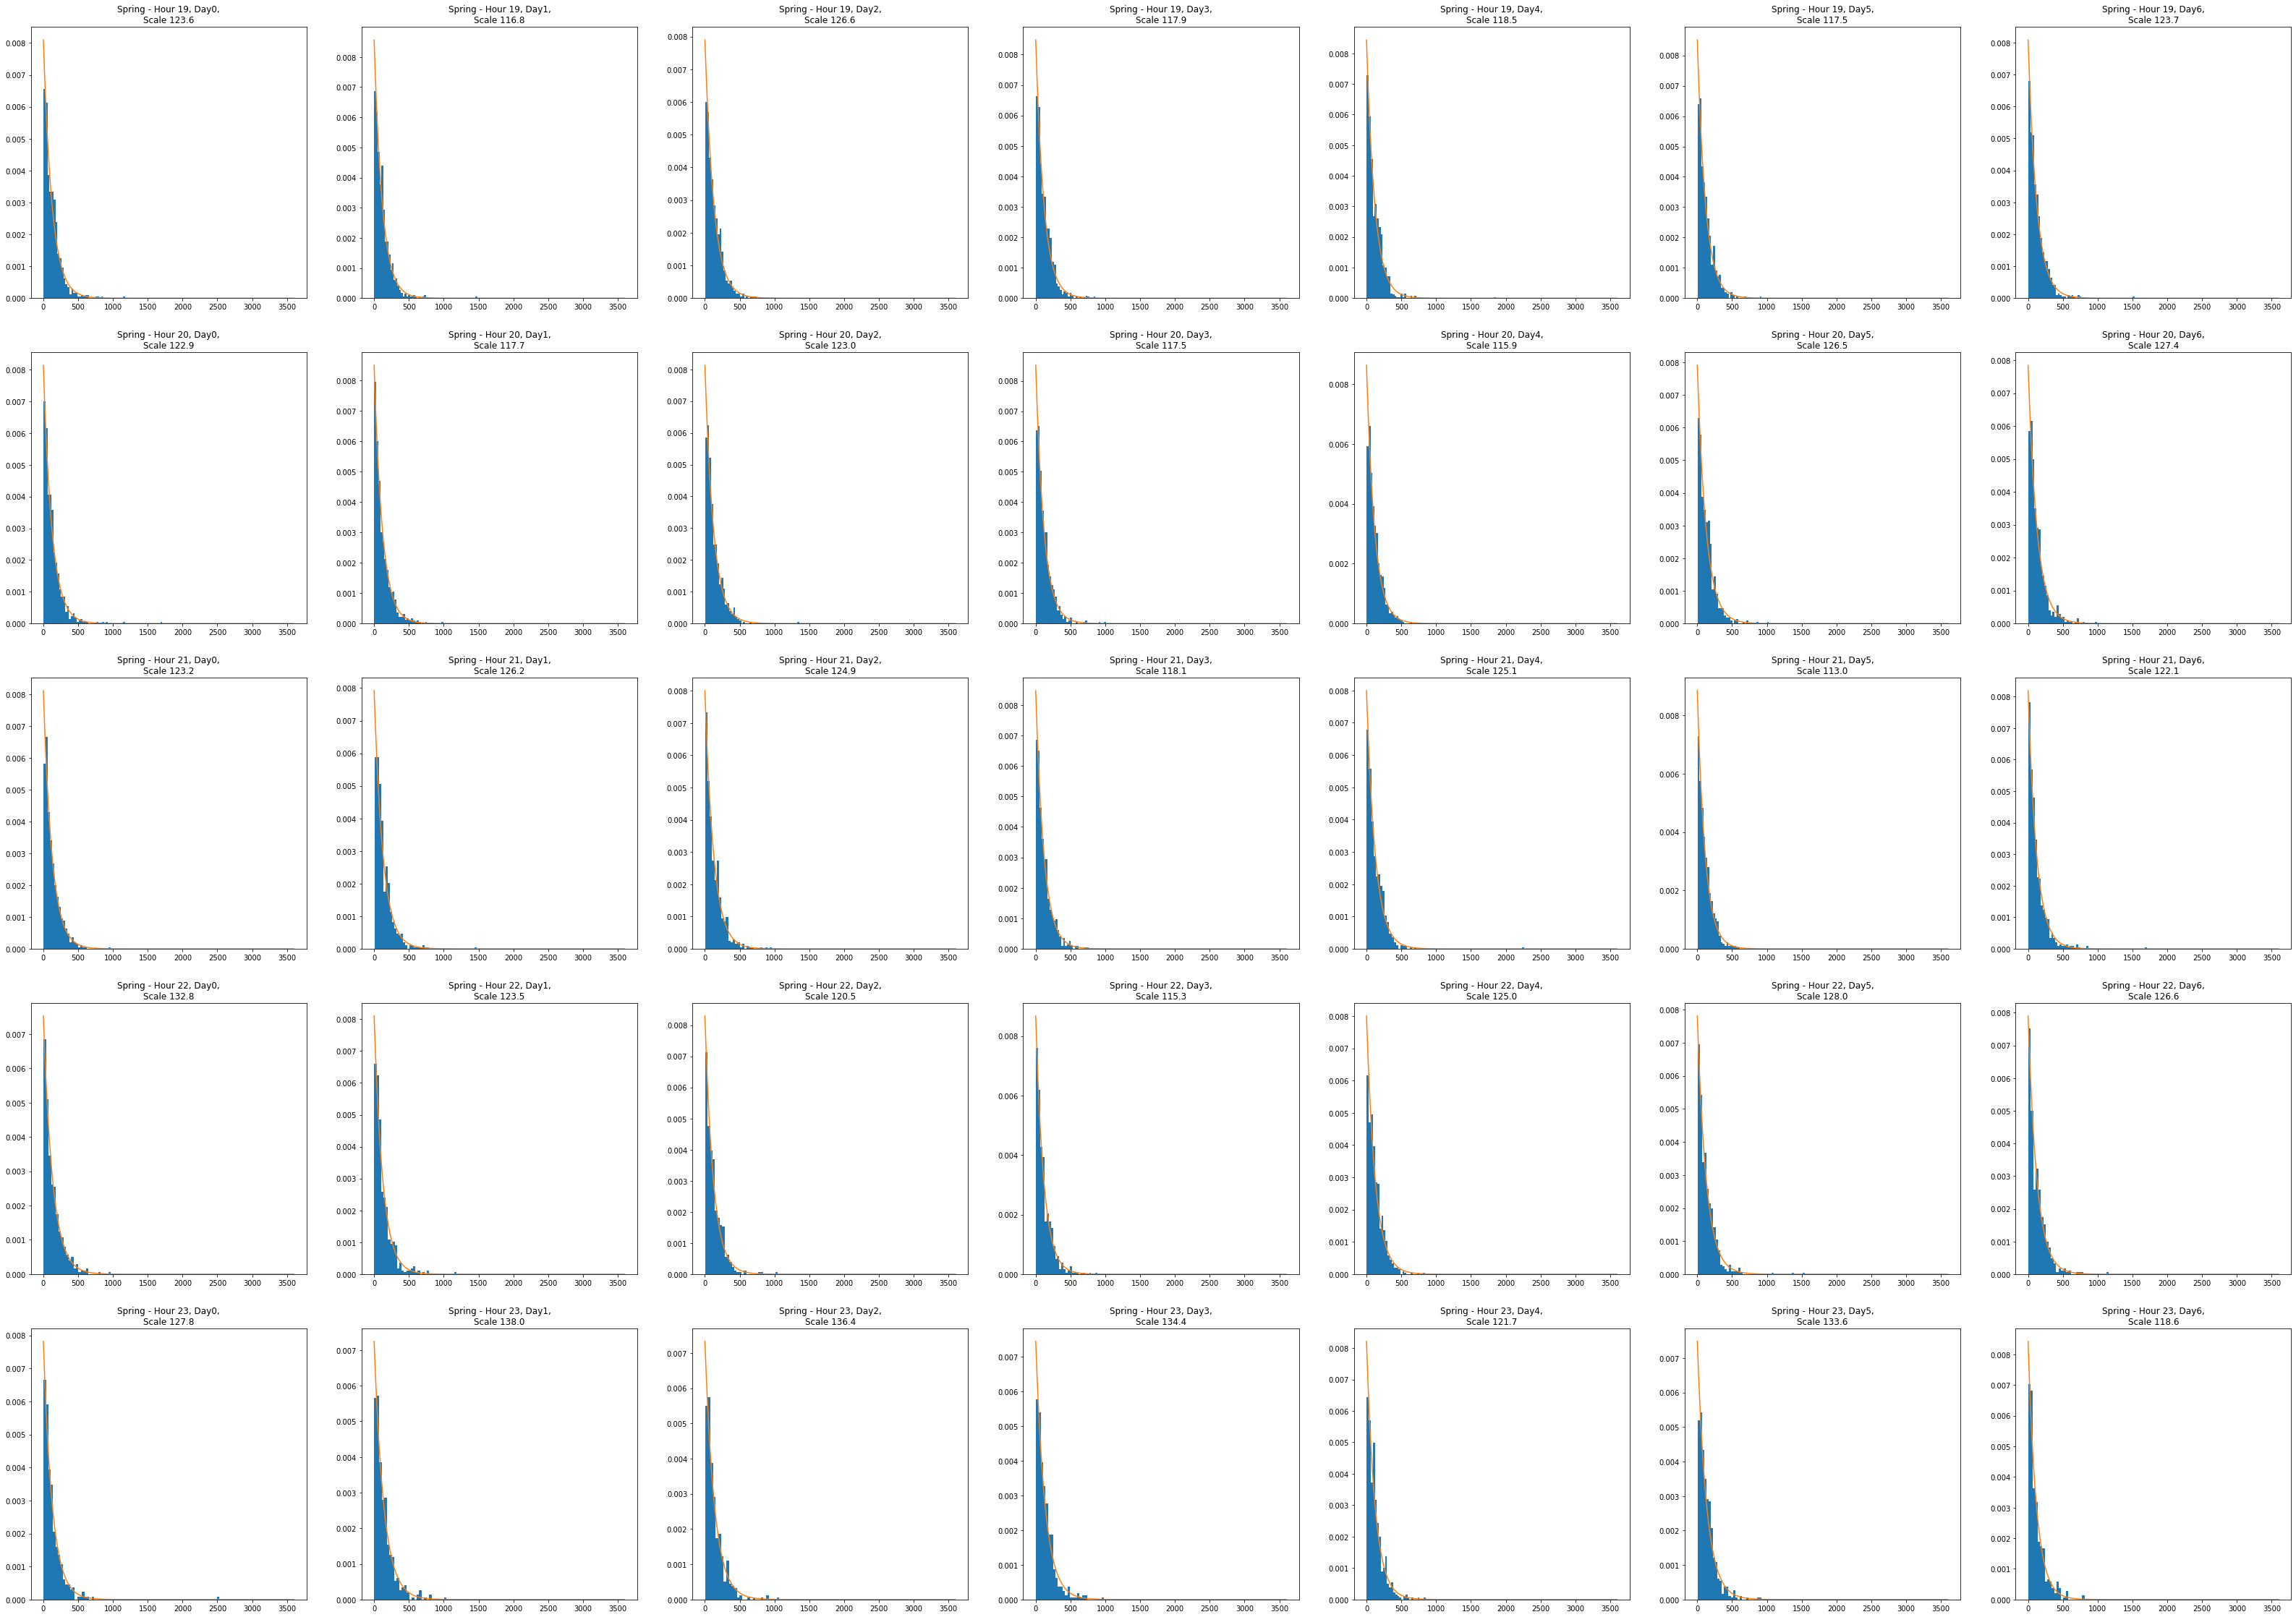

In [81]:
fig, ax = plt.subplots(nrows=5, ncols=7, figsize=(56, 40))

for h in range(19,24):
    for d in range(7):
        dur = breakdown[(h,d,'spring')]['Duration'].astype('timedelta64[s]')
        loc, scale = expon.fit(dur)
        model = expon.pdf(x_axis, scale=scale)
        ax[h%19,d].hist(dur, bins='auto', density=True)
        ax[h%19,d].plot(x_axis, model)
        ax[h%19,d].set_title('Spring - Hour ' + str(h) + ', Day' + str(d) + ',\nScale {:.1f}'.format(scale))
plt.show()

In [86]:
spring_arrival_scale = np.empty(shape=(24,7))
summer_arrival_scale = np.empty(shape=(24,7))
fall_arrival_scale = np.empty(shape=(24,7))

spring_service_scale = np.empty(shape=(24,7))
summer_service_scale = np.empty(shape=(24,7))
fall_service_scale = np.empty(shape=(24,7))

In [92]:
for h in range(24):
    for d in range(7):
        for t in ['spring', 'summer', 'fall']:
            diff = breakdown[(h,d,t)]['Difference'].astype('timedelta64[s]')
            service = breakdown[(h,d,t)]['Duration'].astype('timedelta64[s]')
            arrival_loc, arrival_scale = expon.fit(diff)
            service_loc, service_scale = expon.fit(service)
            if t=='spring':
                spring_arrival_scale[h,d] = arrival_scale
                spring_service_scale[h,d] = service_scale
            elif t=='summer':
                summer_arrival_scale[h,d] = arrival_scale
                summer_service_scale[h,d] = service_scale
            else:
                fall_arrival_scale[h,d] = arrival_scale
                fall_service_scale[h,d] = service_scale

In the diagram below, a smaller value (darker color) indicates less time on average between subsequent phone calls. In other words, the smaller the value, the faster phone calls are coming in. Each row depicts the hour of the day, and each column depicts the day of the week with index 0 being Monday.

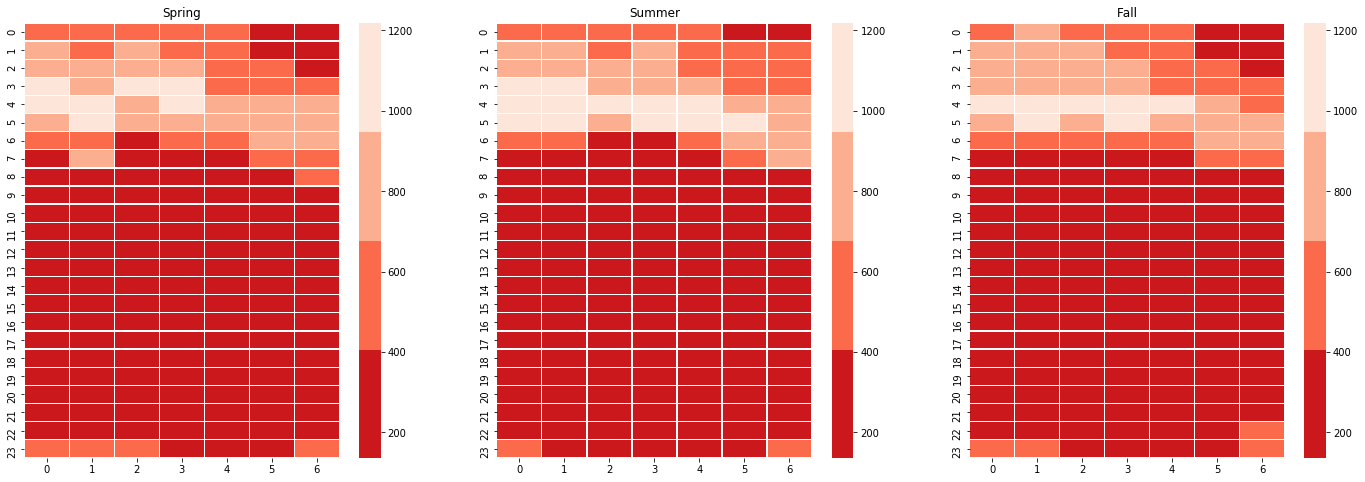

In [113]:
vmin = min(spring_arrival_scale.min(), summer_arrival_scale.min(), fall_arrival_scale.min())
vmax = max(spring_arrival_scale.max(), summer_arrival_scale.max(), fall_arrival_scale.max())
cmap = ['#cb181d', '#fb6a4a', '#fcae91', '#fee5d9']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

sns.heatmap(spring_arrival_scale, ax=ax[0], linewidths=0.25, vmin=vmin, vmax=vmax, cmap=cmap)
sns.heatmap(summer_arrival_scale, ax=ax[1], linewidths=0.25, vmin=vmin, vmax=vmax, cmap=cmap)
sns.heatmap(fall_arrival_scale, ax=ax[2], linewidths=0.25, vmin=vmin, vmax=vmax, cmap=cmap)
ax[0].set_title('Spring')
ax[1].set_title('Summer')
ax[2].set_title('Fall')
plt.show()

The diagram below depicts the average call handling time by hour of the day, and day of the week. Unlike above where smaller values are undesirable for staffing purposes, larger values are undesirable in this view because 911 operators will be tied up longer.

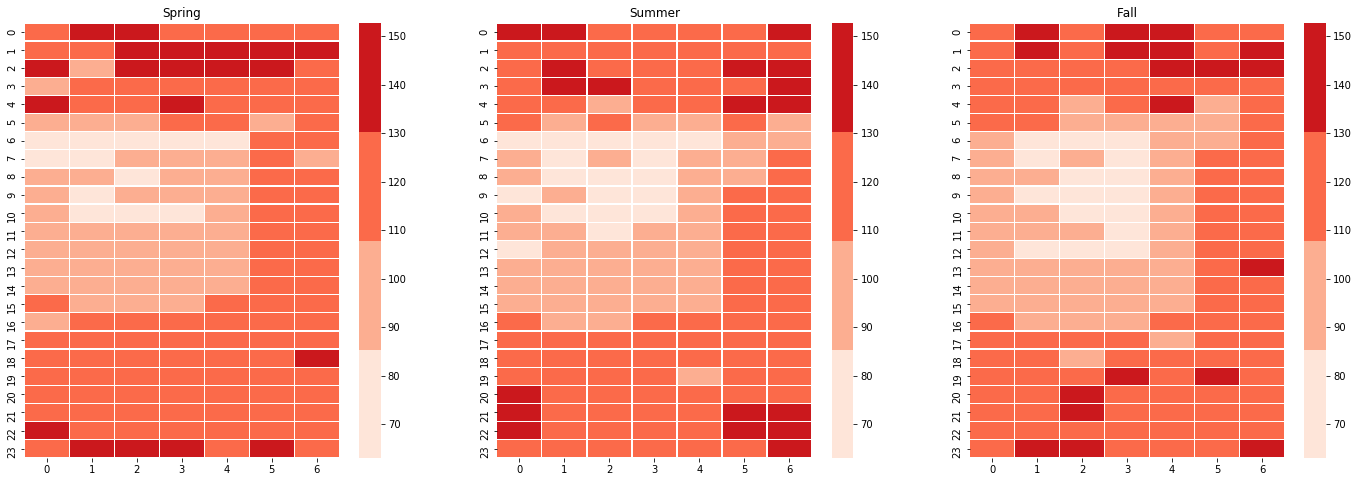

In [114]:
vmin = min(spring_service_scale.min(), summer_service_scale.min(), fall_service_scale.min())
vmax = max(spring_service_scale.max(), summer_service_scale.max(), fall_service_scale.max())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

sns.heatmap(spring_service_scale, ax=ax[0], linewidths=0.25, vmin=vmin, vmax=vmax, cmap=cmap[::-1])
sns.heatmap(summer_service_scale, ax=ax[1], linewidths=0.25, vmin=vmin, vmax=vmax, cmap=cmap[::-1])
sns.heatmap(fall_service_scale, ax=ax[2], linewidths=0.25, vmin=vmin, vmax=vmax, cmap=cmap[::-1])
ax[0].set_title('Spring')
ax[1].set_title('Summer')
ax[2].set_title('Fall')
plt.show()

In [112]:
df['Duration'].sum()

Timedelta('478 days 20:43:17')